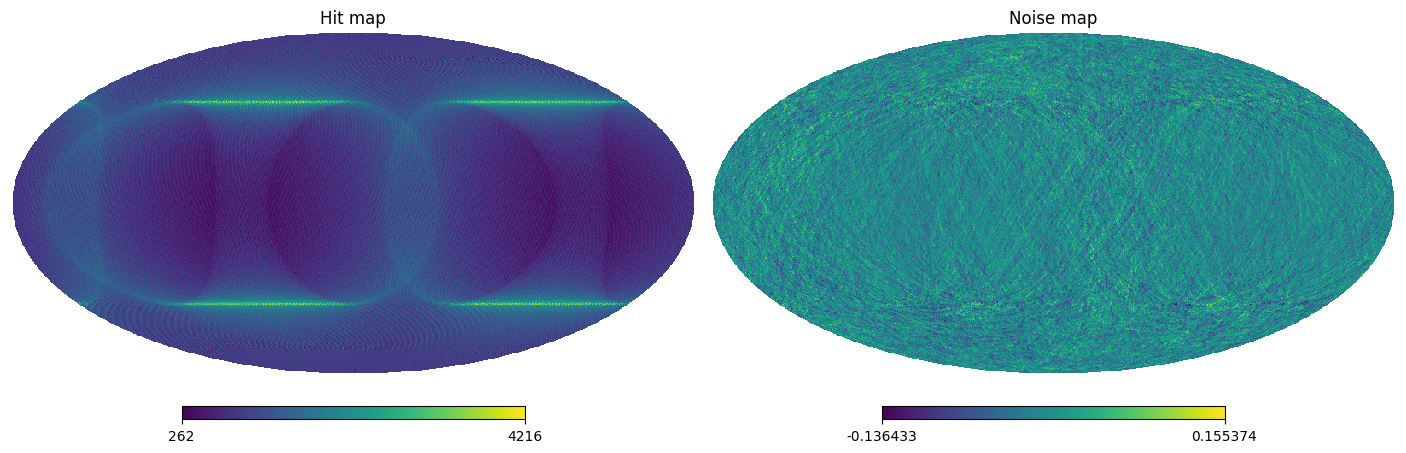

CPU times: user 54 s, sys: 6.55 s, total: 1min
Wall time: 31 s


In [1]:
%%time

import sys, os
sys.path.append(os.path.abspath("../mylib_project"))

from mylib import add_lbsNoise

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from uuid import UUID
from numba import njit
import litebird_sim as lbs



# SIMULATION

nside = 2**7 # map resolution
start_time = 0
chunk_length = 3600 * 6
number_of_days = 120
duration_s = 86400 * number_of_days 

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=duration_s,
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
)



# SCANNING STRATEGY (from IMO)

sim.set_scanning_strategy(
    lbs.SpinningScanningStrategy.from_imo(imo=lbs.Imo(lbs.PTEP_IMO_LOCATION), url=UUID("117fd641-a925-4eeb-9fda-f7c468682108")),
    delta_time_s=120.0
)



# INSTRUMENT & DETECTOR

instrument = lbs.InstrumentInfo(
    boresight_rotangle_rad=0.0,
    spin_boresight_angle_rad=np.deg2rad(90),
    spin_rotangle_rad=np.deg2rad(75)
)
sim.set_instrument(instrument)

det = lbs.DetectorInfo(
    name="Boresight_detector",
    sampling_rate_hz=20.0, 
    bandcenter_ghz=100.0,
    net_ukrts=50.0,
    fknee_mhz=500.0,
    fmin_hz=1e-5,
    alpha=1
)



# OBSERVATION

sim.create_observations(detectors=det)
obs = sim.observations[0]



# POINTINGS

lbs.prepare_pointings(obs, instrument, sim.spin2ecliptic_quats)
pointings, _ = obs.get_pointings("all")

theta = pointings[0, :, 0]
phi   = pointings[0, :, 1]
pixidx = hp.ang2pix(nside, theta, phi)



# NOISE

tod = obs.tod                                  
add_lbsNoise(tod, det, block_duration_s=chunk_length)



# MAP

# Scanning map
m_scan = np.bincount(pixidx, minlength=hp.nside2npix(nside))

# Noise map
m_noise = np.bincount(pixidx, weights=tod[0], minlength=hp.nside2npix(nside))

# PLOT HEALPIX MAP

plt.figure(figsize=(14, 6))

hp.mollview(m_scan, title="Hit map", sub=(1,2,1))

hp.mollview(m_noise, title="Noise map", sub=(1,2,2))

plt.savefig("hp_lbs.pdf")
plt.show()

In [2]:
import numpy as np

# number of pixels observed (value > 0) 
num_nonzero = np.count_nonzero(m_scan)

# total number of pixels
total_pix = len(m_scan)

# percentage of sky observed
percent_obs = (num_nonzero / total_pix) * 100

print("Number of pixels observed:", num_nonzero) # → when the map is completly covered must be = 12*(nside)^2 = 3145728
print("Percentage of sky observed: {:.2f}%".format(percent_obs))


Number of pixels observed: 196608
Percentage of sky observed: 100.00%


In [2]:
def sum_squared(v) -> float:
    acc = 0.0
    for i in range(len(v)):
        acc += v[i] * v[i]

    return acc

@njit
def sum_squared_numba(v) -> float:
    acc = 0.0
    for i in range(len(v)):
        acc += v[i] * v[i]

    return acc


In [5]:
x = np.random.randn(10000000)

In [6]:
%time sum_squared(x)

CPU times: user 2.28 s, sys: 269 μs, total: 2.28 s
Wall time: 2.28 s


9996475.917325726

In [8]:
%time sum_squared_numba(x)

CPU times: user 30.5 ms, sys: 110 μs, total: 30.6 ms
Wall time: 30.4 ms


9996475.917325726